# PINN_NF2_visualization
> Draw field line

PINN

1. Get `b_bottom`
1. Create boundary data and normalize -> boundary_data = boundary_data/b_norm
1. Get coordinates using `create_coordinates` and normalize -> coords = coords/spatial_norm

Since we only have the result `model` which is trained by normalized data, 
so we need to supply normalized coordinates to `model`
and convert the result (actually just multiply b_norm and spatial_norm) to the real value.

In [ ]:
#| default_exp pinn_nf2_visualization

In [ ]:
#| export
import os
import torch
import numpy as np
import pyvista as pv
from tqdm import tqdm
from zpinn.pinn_nf2_cleanup import BModel, create_coordinates

/userhome/jeon_mg/mambaforge/envs/pinf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [ ]:
save_path = '/userhome/jeon_mg/workspace/zpinn/nbs/pinn/model_010000.pt'

In [ ]:
#| export
def create_physical_coordinates(bounds, resolutions):
    x_1D = np.linspace(bounds[0], bounds[1], resolutions[0])
    y_1D = np.linspace(bounds[2], bounds[3], resolutions[1])
    z_1D = np.linspace(bounds[4], bounds[5], resolutions[2])
    x_spacing = np.diff(x_1D)[0]
    y_spacing = np.diff(y_1D)[0]
    z_spacing = np.diff(z_1D)[0]
    spacing = (x_spacing, y_spacing, z_spacing)
    origin = (x_1D[0], y_1D[0], z_1D[0]) # The bottom left corner of the data set
    grid = pv.ImageData(dimensions=resolutions, spacing=spacing, origin=origin)
    return grid

In [ ]:
#| export
class pinn_cube:
    def __init__(self, save_path):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.state = torch.load(save_path, map_location=self.device)
        self.model = self.state['model']
        self.cube_shape = self.state['cube_shape']
        self.b_norm = self.state['b_norm']
        self.spatial_norm = self.state['spatial_norm']
        
    def calculate_magnetic_fields(self, batch_size = 10000):
        device = self.device
        spatial_norm = self.spatial_norm
        b_norm = self.b_norm
        model = self.model
        
        Nx, Ny, Nz = self.cube_shape
        domain_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
        resolutions = (Nx, Ny, Nz)
        grid = create_physical_coordinates(domain_bounds, resolutions)
        domain_coords = np.array(grid.points)
        normalized_domain_coords = domain_coords / spatial_norm
        normalized_domain_coords = normalized_domain_coords.astype(np.float32)
        normalized_domain_coords = torch.tensor(normalized_domain_coords)
        n_batch = int(np.ceil(normalized_domain_coords.shape[0] / batch_size))

        cube = []
        for k in tqdm(range(n_batch)):
            batch_coords = normalized_domain_coords[k*batch_size : (k+1)*batch_size]
            batch_coords.to(device)
            cube += [model(batch_coords).detach().cpu()]
        cube = torch.cat(cube)
        B = cube.numpy()*b_norm
        
        Bx = B[:, 0]
        By = B[:, 1]
        Bz = B[:, 2]

        vectors = np.empty((grid.n_points, 3))
        vectors[:, 0] = Bx
        vectors[:, 1] = By
        vectors[:, 2] = Bz
        grid['B'] = vectors
        grid.active_vectors_name = 'B'
        magnitude = np.linalg.norm(vectors, axis=-1)
        grid['mag'] = magnitude
        grid.active_scalars_name = 'mag'

        self.grid = grid
        return self.grid

In [ ]:
pinn = pinn_cube(save_path)

In [ ]:
pinn.state

{'iteration': 10000,
 'model': DataParallel(
   (module): BModel(
     (d_in): Linear(in_features=3, out_features=256, bias=True)
     (linear_layers): ModuleList(
       (0): Linear(in_features=256, out_features=256, bias=True)
       (1): Linear(in_features=256, out_features=256, bias=True)
       (2): Linear(in_features=256, out_features=256, bias=True)
       (3): Linear(in_features=256, out_features=256, bias=True)
       (4): Linear(in_features=256, out_features=256, bias=True)
       (5): Linear(in_features=256, out_features=256, bias=True)
       (6): Linear(in_features=256, out_features=256, bias=True)
       (7): Linear(in_features=256, out_features=256, bias=True)
     )
     (d_out): Linear(in_features=256, out_features=3, bias=True)
   )
 ),
 'cube_shape': (64, 64, 64),
 'b_norm': 100,
 'spatial_norm': 32,
 'loss_bc': array(4.5926132e-07, dtype=float32),
 'w_bc': 63.09573444803282,
 'loss_div': array(7.973204e-06, dtype=float32),
 'w_div': 1,
 'loss_ff': array(2.0497127e-0

In [ ]:
pinn.calculate_magnetic_fields(batch_size=10000)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:01<00:00, 23.70it/s]


ImageData (0x7f5cf25cef80)
  N Cells:      250047
  N Points:     262144
  X Bounds:     0.000e+00, 6.300e+01
  Y Bounds:     0.000e+00, 6.300e+01
  Z Bounds:     0.000e+00, 6.300e+01
  Dimensions:   64, 64, 64
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

## Visualization

In [ ]:
#| export
import copy
import matplotlib.pyplot as plt

In [ ]:
pv.set_jupyter_backend('static')

In [ ]:
# Only for jupyter notebook or lab
# pv.start_xvfb()
# pv.global_theme.trame.server_proxy_enabled = True

In [ ]:
#| export
class draw_grid:
    def __init__(self, grd):
        grid = copy.deepcopy(grd)
        self.grid = grid
        x_ind_min, y_ind_min, z_ind_min = 0, 0, 0
        Nx, Ny, Nz = self.grid.dimensions
        x_ind_max, y_ind_max, z_ind_max = Nx-1, Ny-1, Nz-1
        
        bottom_subset = (x_ind_min, x_ind_max, y_ind_min, y_ind_max, 0, 0)
        bottom = self.grid.extract_subset(bottom_subset).extract_surface()
        bottom.active_vectors_name = 'B'
        bottom.active_scalars_name = 'mag'

        self.bottom = bottom

        self.x_bottom = bottom.points[:, 0].reshape(Nx, Ny)
        self.y_bottom = bottom.points[:, 1].reshape(Nx, Ny)
        self.B_bottom = bottom['B'].reshape(Nx, Ny, 3)

    def plt_Bz(self):
        plt.close()
        fig, ax = plt.subplots(figsize=(6,6))
        CS = plt.contour(self.x_bottom, self.y_bottom, self.B_bottom[:, :, 2], 
                         origin='lower', colors='k')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.clabel(CS, fontsize=9, inline=True)
        ax.set_title(r"$B_z(z=0)$")
        plt.show()

    def k3d_bottom(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        p.add_mesh(self.bottom)
        p.show()

    def pv_bottom(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        p.add_mesh(self.bottom)
        p.show()

    def pv_Bz_2D(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        sargs = dict(title="B_z")
        ctr = self.bottom.contour(scalars=self.bottom['B'][:, 2])
        p.add_mesh(ctr, cmap='plasma', scalar_bar_args=sargs)
        p.show()

    def pv_Bz_3D(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        sargs = dict(title="B_z")
        ctr = self.grid.contour(scalars=self.grid['B'][:, 2])
        p.add_mesh(ctr, cmap='plasma', scalar_bar_args=sargs, opacity=0.5)
        p.show()

    def pv_streamline(self):
        p = pv.Plotter()
        p.show_bounds()
        p.add_mesh(self.grid.outline())
        i_size = self.grid.bounds[1]-self.grid.bounds[0]
        j_size = self.grid.bounds[3]-self.grid.bounds[2]
        seed = pv.Plane(center=(self.grid.center[0], self.grid.center[1], 0), direction=(0,0,1), 
                i_size=i_size, j_size=j_size, 
                i_resolution=10, j_resolution=10)
        p.add_mesh(seed)
        strl = self.grid.streamlines_from_source(seed,
                                                 vectors='B',
                                                 max_time=180,
                                                 initial_step_length=0.1,
                                                 integration_direction='both')
        
        p.add_mesh(strl.tube(radius=i_size/400), cmap='bwr', ambient=0.2)

        sargs = dict(title="B_z")
        ctr = self.bottom.contour(scalars=self.bottom['B'][:, 2])
        p.add_mesh(ctr, cmap='plasma', scalar_bar_args=sargs)
        p.show()


In [ ]:
pi = draw_grid(pinn.grid)

In [ ]:
import pickle

In [ ]:
with open("/userhome/jeon_mg/workspace/zpinn/nbs/input/original/b.pickle","rb") as f:
    b = pickle.load(f)
ll = draw_grid(b.grid)

In [ ]:
ll.grid

ImageData (0x7f5cf2098ac0)
  N Cells:      250047
  N Points:     262144
  X Bounds:     -1.000e+00, 1.000e+00
  Y Bounds:     -1.000e+00, 1.000e+00
  Z Bounds:     0.000e+00, 2.000e+00
  Dimensions:   64, 64, 64
  Spacing:      3.175e-02, 3.175e-02, 3.175e-02
  N Arrays:     3

In [ ]:
pi.grid

ImageData (0x7f5cf25cf160)
  N Cells:      250047
  N Points:     262144
  X Bounds:     0.000e+00, 6.300e+01
  Y Bounds:     0.000e+00, 6.300e+01
  Z Bounds:     0.000e+00, 6.300e+01
  Dimensions:   64, 64, 64
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
ll.bottom

PolyData (0x7f5cf20992a0)
  N Cells:    3969
  N Points:   4096
  N Strips:   0
  X Bounds:   -1.000e+00, 1.000e+00
  Y Bounds:   -1.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   5

In [ ]:
pi.bottom

PolyData (0x7f5cf25cdf00)
  N Cells:    3969
  N Points:   4096
  N Strips:   0
  X Bounds:   0.000e+00, 6.300e+01
  Y Bounds:   0.000e+00, 6.300e+01
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   4

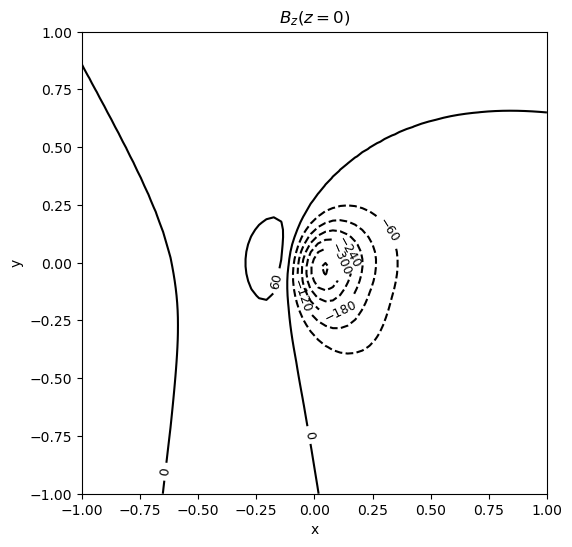

In [ ]:
ll.plt_Bz()

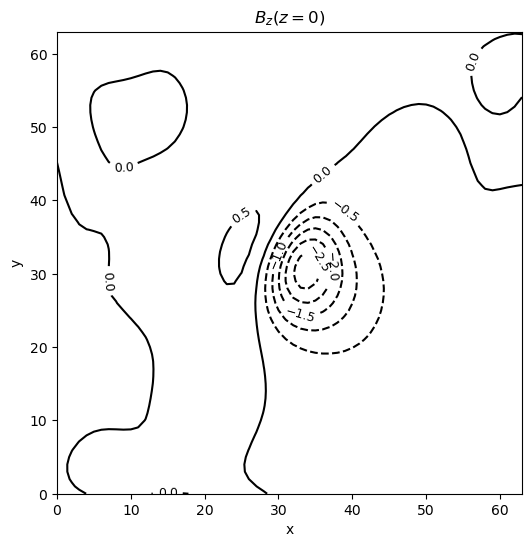

In [ ]:
pi.plt_Bz()

In [ ]:
ll.pv_bottom()

: 

: 

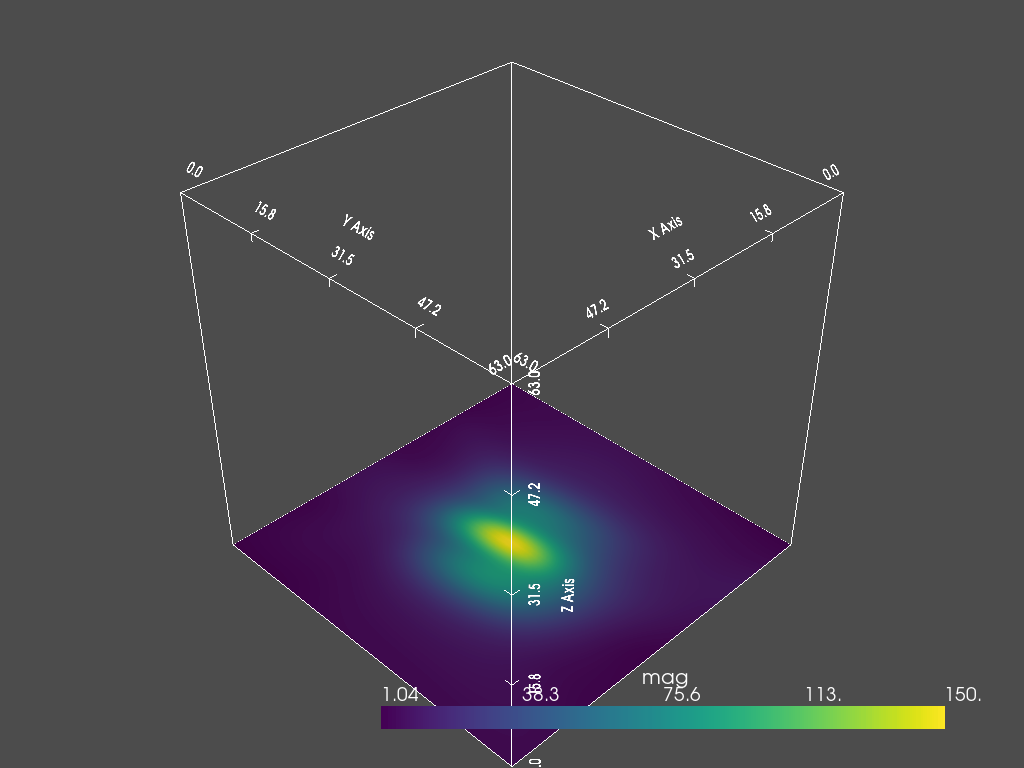

In [ ]:
pi.pv_bottom()

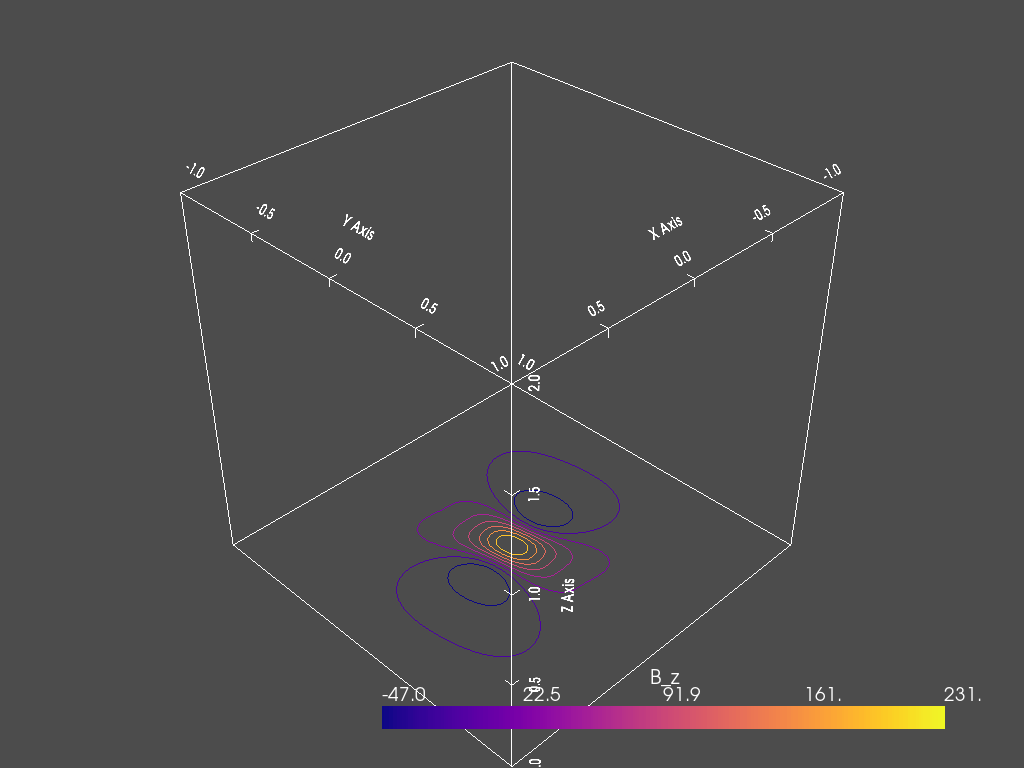

In [ ]:
ll.pv_Bz_2D()

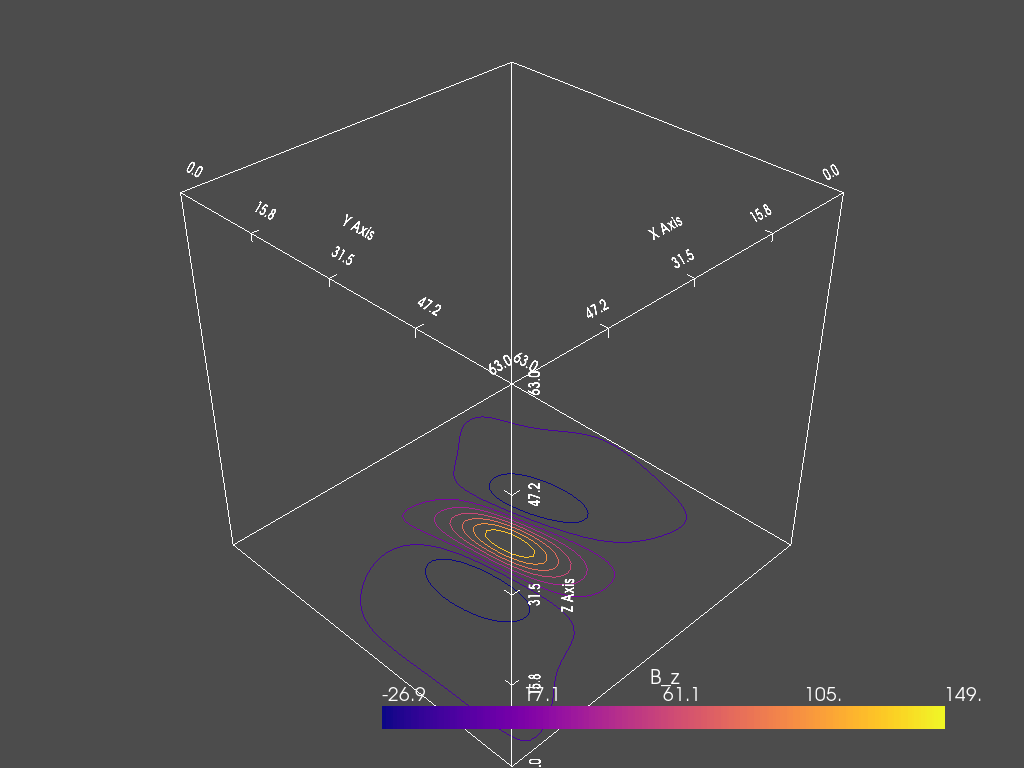

In [ ]:
pi.pv_Bz_2D()

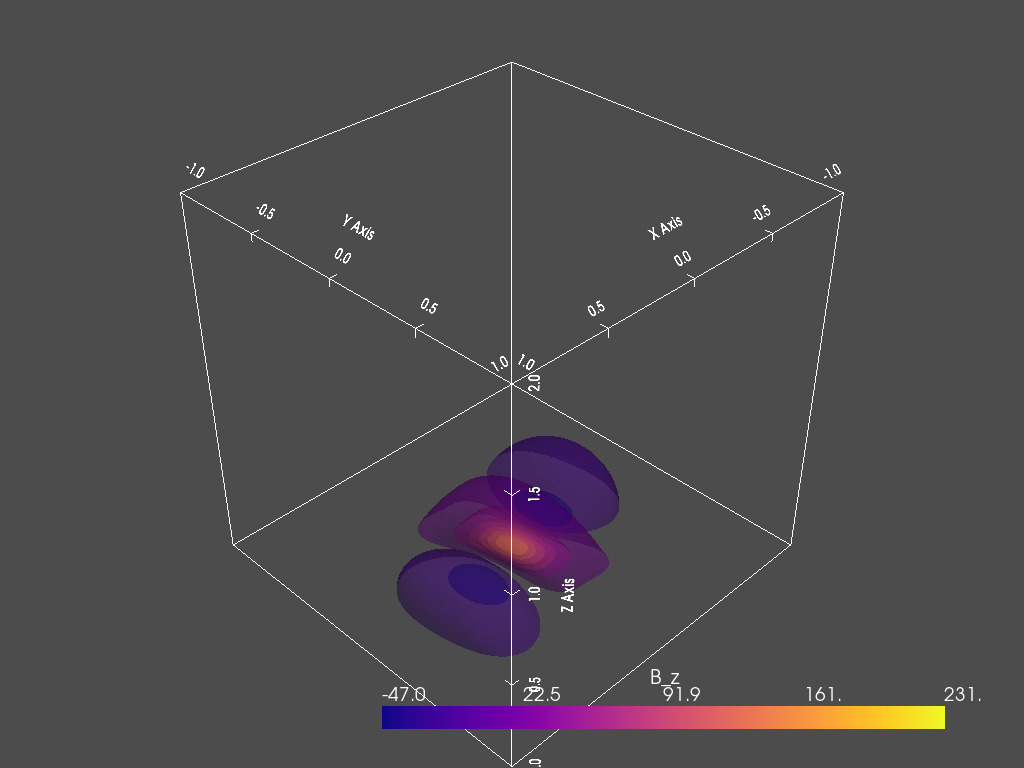

In [ ]:
ll.pv_Bz_3D()

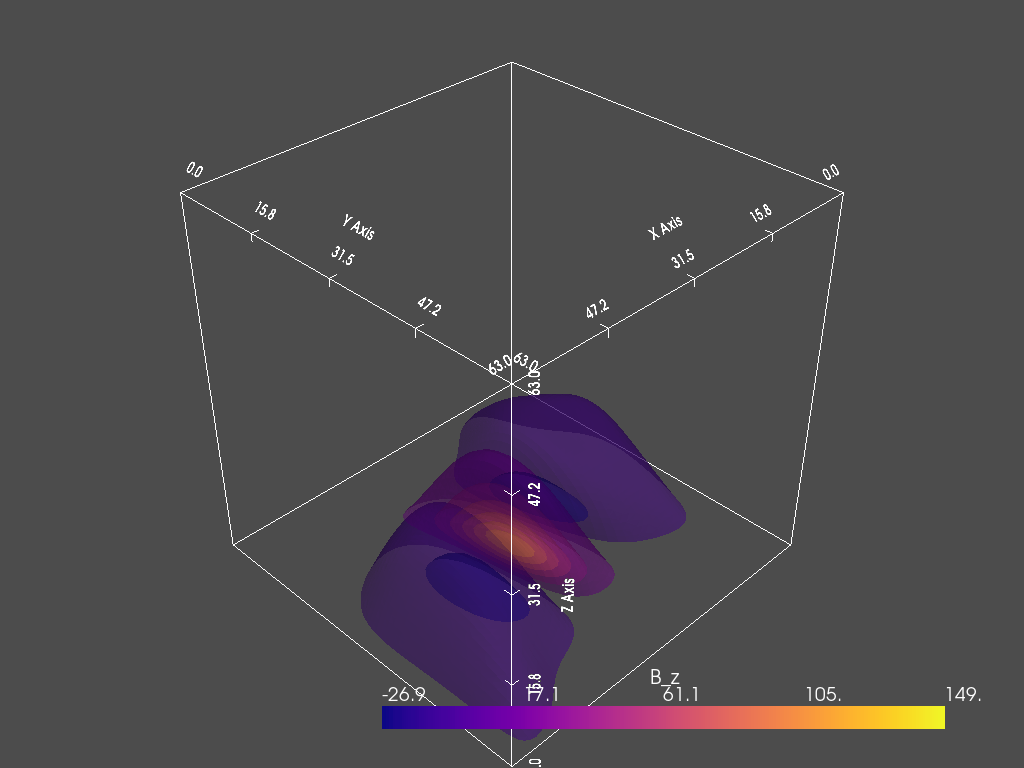

In [ ]:
pi.pv_Bz_3D()

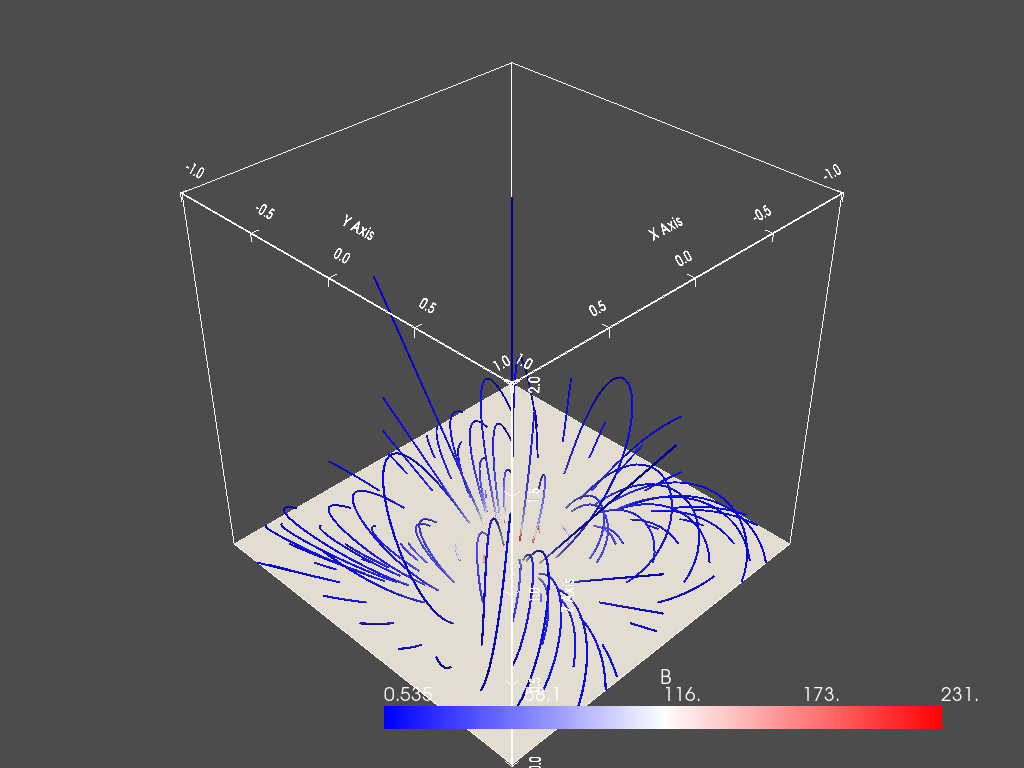

In [ ]:
ll.pv_streamline()

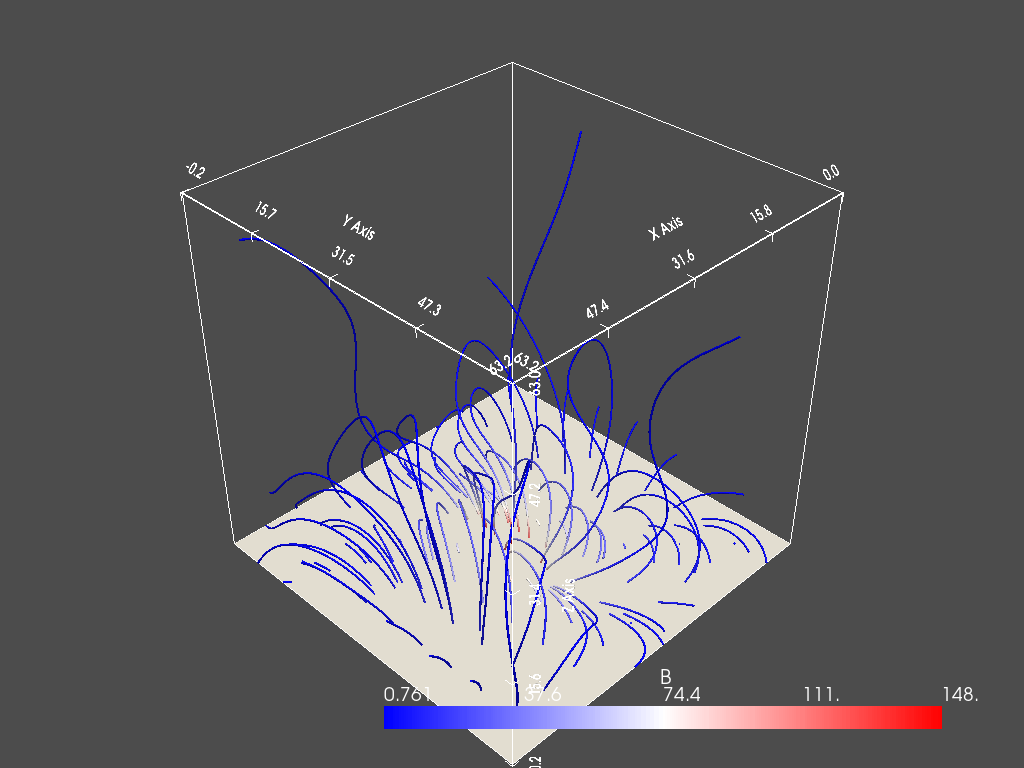

In [ ]:
pi.pv_streamline()